## Appendix A, ML Engineering in Action
##### Author: Ben Wilson

This is the complimentary code to the dog examples throughout Appendix A. Included here mostly for fun.

In [16]:
import nltk
import pandas as pd
import numpy as np

#### Listing 11.1 Nested loop name reconciliation example
We've got a list of registered names here "client_names" and a collection of names that have been extracted from free-form text reviews. Since most of our customers are writing these reviews on cellphones, their spelling is absolutely terrible when referencing their dogs by name. We need to reconcile these.

In [17]:
client_names = ['Rover', 'ArtooDogTwo', 'Willy', 'Hodor', 'MrWiggleBottoms', 'SallyMcBarksALot', 
                'HungryGames', 'MegaBite', 'HamletAndCheese', 'HoundJamesHound', 'Treatzilla', 
                'SlipperAssassin', 'Chewbarka', 'SirShedsALot', 'Spot', 'BillyGoat', 'Thunder', 
                'Doggo', 'TreatHunter']

extracted_names = ['Slipr Assassin', 'Are two dog two', 'willy', 'willie', 'hodr', 'hodor', 'treat zilla', 
                   'roover', 'megbyte', 'sport', 'spotty', 'billygaot', 'billy goat', 'thunder', 'thunda',
                   'sirshedlot', 'chew bark', 'hungry games', 'ham and cheese', 'mr wiggle bottom', 
                   'sally barks a lot']

In [18]:
def lower_strip(string): return string.lower().replace(" ", "")

def get_closest_match(registered_names, extracted_names):
    scores = {}
    for i in registered_names:
        for j in extracted_names:
            scores['{}_{}'.format(i, j)] = nltk.edit_distance(lower_strip(i), lower_strip(j))
    parsed = {}
    for k, v in scores.items():
        k1, k2 = k.split('_')
        low_value = parsed.get(k2)
        if low_value is not None and (v < low_value[1]):
            parsed[k2] = (k1, v)
        elif low_value is None:
            parsed[k2] = (k1, v)
    return parsed

In [19]:
get_closest_match(client_names, extracted_names)

{'Slipr Assassin': ('SlipperAssassin', 2),
 'Are two dog two': ('ArtooDogTwo', 2),
 'willy': ('Willy', 0),
 'willie': ('Willy', 2),
 'hodr': ('Hodor', 1),
 'hodor': ('Hodor', 0),
 'treat zilla': ('Treatzilla', 0),
 'roover': ('Rover', 1),
 'megbyte': ('MegaBite', 2),
 'sport': ('Spot', 1),
 'spotty': ('Spot', 2),
 'billygaot': ('BillyGoat', 2),
 'billy goat': ('BillyGoat', 0),
 'thunder': ('Thunder', 0),
 'thunda': ('Thunder', 2),
 'sirshedlot': ('SirShedsALot', 2),
 'chew bark': ('Chewbarka', 1),
 'hungry games': ('HungryGames', 0),
 'ham and cheese': ('HamletAndCheese', 3),
 'mr wiggle bottom': ('MrWiggleBottoms', 1),
 'sally barks a lot': ('SallyMcBarksALot', 2)}

This brute-force n^2 strategy is basically the worst way to solve this. It won't scale very well. Let's try a different approach...

#### Listing 11.2 A slightly better approach (but still not perfect)
If we really wanted to make this better, we'd use a lucene-backed implementation where we are doing fuzzy match search with a tool such as ElasticSearch or a NoSQL engine that can support queries with fuzzy matching. For the purposes of this example, we'll keep it in Python.

In [20]:
JOIN_KEY = 'joinkey'
CLIENT_NM = 'client_names'
EXTRACT_NM = 'extracted_names'
DISTANCE_NM = 'levenshtein'

def dataframe_reconciliation(registered_names, extracted_names, threshold=10):
    C_NAME_RAW = CLIENT_NM + '_raw'
    E_NAME_RAW = EXTRACT_NM + '_raw'
    registered_df = pd.DataFrame(registered_names, columns=[CLIENT_NM])
    registered_df[JOIN_KEY] = 0
    registered_df[C_NAME_RAW] = registered_df[CLIENT_NM].map(lambda x: lower_strip(x))
    extracted_df = pd.DataFrame(extracted_names, columns=[EXTRACT_NM])
    extracted_df[JOIN_KEY] = 0
    extracted_df[E_NAME_RAW] = extracted_df[EXTRACT_NM].map(lambda x: lower_strip(x))
    joined_df = registered_df.merge(extracted_df, on=JOIN_KEY, how='outer')
    joined_df[DISTANCE_NM] = joined_df.loc[:, [C_NAME_RAW, E_NAME_RAW]].apply(
        lambda x: nltk.edit_distance(*x), axis=1)
    joined_df = joined_df.drop(JOIN_KEY, axis=1)
    filtered = joined_df[joined_df[DISTANCE_NM] < threshold]
    filtered = filtered.sort_values(DISTANCE_NM).groupby(EXTRACT_NM, as_index=False).first()
    return filtered.drop([C_NAME_RAW, E_NAME_RAW], axis=1)

In [21]:
match_results = dataframe_reconciliation(client_names, extracted_names, 9)

Generating the plot for figure 11.2 in the book...

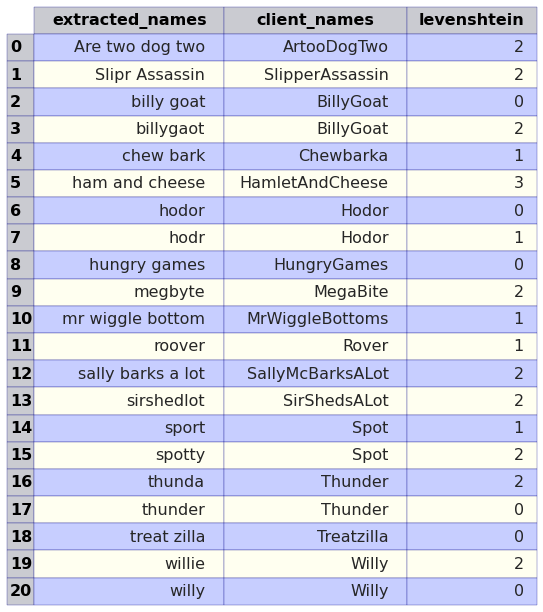

In [22]:
import matplotlib.pyplot as plt
import six

with plt.style.context('seaborn'):
    size = (np.array(match_results.shape[::-1]) + np.array([0, 1])) * np.array([3., 0.5])
    fig, ax = plt.subplots(figsize=size)
    row_colors = ['ivory', '#c7ceff']
    ax.axis('off')
    tbl = ax.table(cellText=match_results.values,
                   colLabels=match_results.columns,
                   rowLabels=match_results.index,
                   bbox=[0,0,1,1]
                  )
    tbl.set_fontsize(16)
    for k, cell in six.iteritems(tbl._cells):
        cell.set_edgecolor('darkblue')
        if k[0] == 0 or k[1] < 0:
            cell.set_text_props(weight='bold', color='black')
            cell.set_facecolor('#cacbd1')
        else:
            cell.set_facecolor(row_colors[k[0]%2])
    tbl.auto_set_column_width(col=list(range(len(match_results.columns))))
    ax.axis('tight')
    plt.savefig('dog_name_matching.svg', format='svg', bbox_inches='tight')

The visualization script for generating figure 11.9 in the book

In [23]:
from itertools import combinations, permutations
import numpy as np

In [33]:
def comb_and_perm(size, interactions=2):
    collection = np.arange(0, size,1)
    perms = permutations(collection, interactions)
    combs = combinations(collection, interactions)
    return {'size': size, 'permutation_count':len(list(perms)), 'combination_count': len(list(combs))}

In [50]:
results = [comb_and_perm(x) for x in np.arange(0,2000)]

In [51]:
results_df = pd.DataFrame(results)

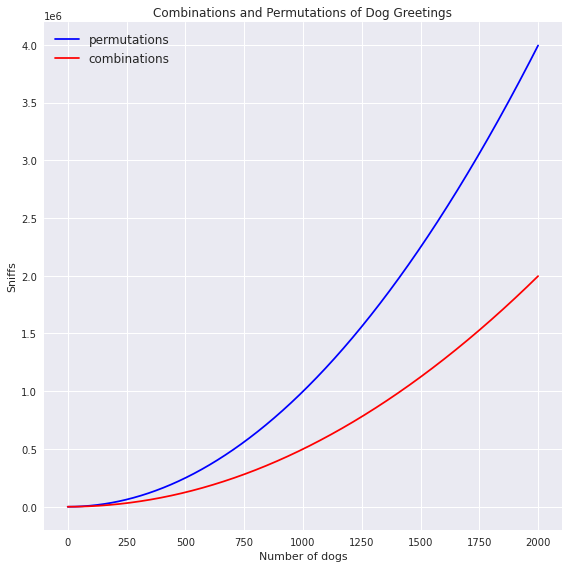

In [52]:
with plt.style.context('seaborn'):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.plot(results_df['size'], results_df['permutation_count'], color='blue', label='permutations')
    ax.plot(results_df['size'], results_df['combination_count'], color='red', label='combinations')
    ax.set_title('Combinations and Permutations of Dog Greetings')
    ax.set_ylabel('Sniffs')
    ax.set_xlabel('Number of dogs')
    ax.legend(loc='best', fontsize=12)
    plt.tight_layout()
    plt.savefig('dog_sniffs.svg', format='svg')